In [1]:
import sys
import os
import random
import torch
import torch.nn.functional as F
import git
import numpy as np
from tqdm import tqdm

sys.path.append("../")

from src.models.disc_models import DiscreteDiagSheafDiffusion, DiscreteBundleSheafDiffusion, DiscreteGeneralSheafDiffusion
from src.utils.parser import get_parser
from src.utils.heterophilic import get_dataset, get_fixed_splits

In [19]:
def reset_wandb_env():
    exclude = {
        "WANDB_PROJECT",
        "WANDB_ENTITY",
        "WANDB_API_KEY",
    }
    for k, v in os.environ.items():
        if k.startswith("WANDB_") and k not in exclude:
            del os.environ[k]


def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)[data.train_mask]
    nll = F.nll_loss(out, data.y[data.train_mask])
    loss = nll
    loss.backward()

    optimizer.step()
    del out

def test(model, data):
    model.eval()
    with torch.no_grad():
        logits, accs, losses, preds = model(data.x), [], [], []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

            loss = F.nll_loss(logits[mask], data.y[mask])

            preds.append(pred.detach().cpu())
            accs.append(acc)
            losses.append(loss.detach().cpu())
        return accs, preds, losses

def run_exp(args, dataset, model_cls, fold):
    data = dataset[0]
    data = get_fixed_splits(data, args['dataset'], fold)
    data = data.to(args['device'])

    model = model_cls(data.edge_index, args)
    model = model.to(args['device'])

    sheaf_learner_params, other_params = model.grouped_parameters()
    optimizer = torch.optim.Adam([
        {'params': sheaf_learner_params, 'weight_decay': args['sheaf_decay']},
        {'params': other_params, 'weight_decay': args['weight_decay']}
    ], lr=args['lr'])

    epoch = 0
    best_val_acc = test_acc = 0
    best_val_loss = float('inf')
    val_loss_history = []
    val_acc_history = []
    best_epoch = 0
    bad_counter = 0
    
    for epoch in range(args['epochs']):
        train(model, optimizer, data)

        [train_acc, val_acc, tmp_test_acc], preds, [
            train_loss, val_loss, tmp_test_loss] = test(model, data)
        if fold == 0:
            res_dict = {
                f'fold{fold}_train_acc': train_acc,
                f'fold{fold}_train_loss': train_loss,
                f'fold{fold}_val_acc': val_acc,
                f'fold{fold}_val_loss': val_loss,
                f'fold{fold}_tmp_test_acc': tmp_test_acc,
                f'fold{fold}_tmp_test_loss': tmp_test_loss,
            }
            wandb.log(res_dict, step=epoch)

        new_best_trigger = val_acc > best_val_acc if args['stop_strategy'] == 'acc' else val_loss < best_val_loss
        if new_best_trigger:
            best_val_acc = val_acc
            best_val_loss = val_loss
            test_acc = tmp_test_acc
            best_epoch = epoch
            bad_counter = 0
            best_preds = preds
        else:
            bad_counter += 1

        if bad_counter == args['early_stopping']:
            break
#haven't tested the following yet        
            
            

    print(f"Fold {fold} | Epochs: {epoch} | Best epoch: {best_epoch}")
    print(f"Test acc: {test_acc:.4f}")
    print(f"Best val acc: {best_val_acc:.4f}")

    if "ODE" not in args['model']:
        # Debugging for discrete models
        for i in range(len(model.sheaf_learners)):
            L_max = model.sheaf_learners[i].L.detach().max().item()
            L_min = model.sheaf_learners[i].L.detach().min().item()
            L_avg = model.sheaf_learners[i].L.detach().mean().item()
            L_abs_avg = model.sheaf_learners[i].L.detach().abs().mean().item()
            print(f"Laplacian {i}: Max: {L_max:.4f}, Min: {L_min:.4f}, Avg: {L_avg:.4f}, Abs avg: {L_abs_avg:.4f}")

        with np.printoptions(precision=3, suppress=True):
            for i in range(0, args['layers']):
                print(f"Epsilons {i}: {model.epsilons[i].detach().cpu().numpy().flatten()}")

    wandb.log({'best_test_acc': test_acc, 'best_val_acc': best_val_acc, 'best_epoch': best_epoch})
    keep_running = False if test_acc < args['min_acc'] else True

    return test_acc, best_val_acc, keep_running, best_preds


In [39]:
#first loss

# setup the parameters
parser = get_parser()
args = parser.parse_args("")

repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha

#rewrite and add some parameters
args.d = 3
args.layers = 4
args.dropout = 0.7
args.dataset = "texas"
args.model = "BundleSheaf"
args.entity = "sheafnn"

dataset = get_dataset(args.dataset)

args.graph_size = dataset[0].x.size(0)
args.input_dim = dataset.num_features
args.output_dim = dataset.num_classes
args.device = torch.device(f'cuda:{args.cuda}' if torch.cuda.is_available() else 'cpu')
assert args.normalised or args.deg_normalised
if args.sheaf_decay is None:
    args.sheaf_decay = args.weight_decay


if args.model == 'DiagSheafODE':
    model_cls = DiagSheafDiffusion
elif args.model == 'BundleSheafODE':
    model_cls = BundleSheafDiffusion
elif args.model == 'GeneralSheafODE':
    model_cls = GeneralSheafDiffusion
elif args.model == 'DiagSheaf':
    model_cls = DiscreteDiagSheafDiffusion
elif args.model == 'BundleSheaf':
    model_cls = DiscreteBundleSheafDiffusion
elif args.model == 'GeneralSheaf':
    model_cls = DiscreteGeneralSheafDiffusion
else:
    raise ValueError(f'Unknown model')


# Set the seed for everything
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

results = []

import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = 'sheafnn_notebook'
wandb.init(project="sheafnn", config=vars(args), entity=args.entity)
    
#train the diffusion process


for fold in tqdm(range(args.folds)):
        test_acc, best_val_acc, keep_running, predictions = run_exp(wandb.config, dataset, model_cls, fold)
        results.append([test_acc, best_val_acc])
        if not keep_running:
            break




 10%|█         | 1/10 [00:08<01:18,  8.72s/it]

Fold 0 | Epochs: 274 | Best epoch: 74
Test acc: 0.7838
Best val acc: 0.7797
Laplacian 0: Max: 0.0162, Min: -0.0731, Avg: -0.0225, Abs avg: 0.0243
Laplacian 1: Max: 0.0467, Min: -0.0778, Avg: -0.0209, Abs avg: 0.0280
Laplacian 2: Max: 0.0870, Min: -0.1352, Avg: -0.0229, Abs avg: 0.0346
Laplacian 3: Max: 0.4127, Min: -0.4122, Avg: -0.0400, Abs avg: 0.1252
Epsilons 0: [0.972 0.949 0.801]
Epsilons 1: [0.983 0.962 0.835]
Epsilons 2: [0.985 0.98  0.84 ]
Epsilons 3: [0.999 1.024 0.854]


 20%|██        | 2/10 [00:24<01:41, 12.70s/it]

Fold 1 | Epochs: 500 | Best epoch: 300
Test acc: 0.9189
Best val acc: 0.8305
Laplacian 0: Max: 0.0131, Min: -0.0874, Avg: -0.0256, Abs avg: 0.0272
Laplacian 1: Max: 0.0196, Min: -0.0800, Avg: -0.0248, Abs avg: 0.0283
Laplacian 2: Max: 0.0287, Min: -0.0758, Avg: -0.0220, Abs avg: 0.0267
Laplacian 3: Max: 0.4582, Min: -0.6166, Avg: -0.0702, Abs avg: 0.1149
Epsilons 0: [1.178 1.181 1.092]
Epsilons 1: [1.148 1.207 1.077]
Epsilons 2: [1.174 1.188 1.095]
Epsilons 3: [1.193 1.2   1.124]


 30%|███       | 3/10 [00:41<01:44, 14.99s/it]

Fold 2 | Epochs: 550 | Best epoch: 350
Test acc: 0.8649
Best val acc: 0.8983
Laplacian 0: Max: 0.0252, Min: -0.0795, Avg: -0.0210, Abs avg: 0.0242
Laplacian 1: Max: 0.0200, Min: -0.0770, Avg: -0.0203, Abs avg: 0.0227
Laplacian 2: Max: 0.0627, Min: -0.0779, Avg: -0.0156, Abs avg: 0.0316
Laplacian 3: Max: 0.1486, Min: -0.1782, Avg: -0.0187, Abs avg: 0.0488
Epsilons 0: [1.171 1.095 1.147]
Epsilons 1: [1.178 1.109 1.128]
Epsilons 2: [1.176 1.119 1.18 ]
Epsilons 3: [1.174 1.123 1.179]


 40%|████      | 4/10 [00:50<01:14, 12.35s/it]

Fold 3 | Epochs: 250 | Best epoch: 50
Test acc: 0.8649
Best val acc: 0.8475
Laplacian 0: Max: 0.0452, Min: -0.0979, Avg: -0.0268, Abs avg: 0.0340
Laplacian 1: Max: 0.0829, Min: -0.1127, Avg: -0.0181, Abs avg: 0.0373
Laplacian 2: Max: 0.2295, Min: -0.2339, Avg: -0.0003, Abs avg: 0.0435
Laplacian 3: Max: 0.5695, Min: -0.6717, Avg: 0.0256, Abs avg: 0.1282
Epsilons 0: [1.012 0.929 0.829]
Epsilons 1: [1.023 0.902 0.849]
Epsilons 2: [1.032 0.942 0.825]
Epsilons 3: [1.032 0.974 0.805]


 50%|█████     | 5/10 [01:08<01:12, 14.59s/it]

Fold 4 | Epochs: 612 | Best epoch: 412
Test acc: 0.8649
Best val acc: 0.9492
Laplacian 0: Max: 0.0174, Min: -0.0711, Avg: -0.0221, Abs avg: 0.0245
Laplacian 1: Max: 0.0237, Min: -0.0824, Avg: -0.0237, Abs avg: 0.0270
Laplacian 2: Max: 0.1002, Min: -0.1300, Avg: -0.0198, Abs avg: 0.0377
Laplacian 3: Max: 0.1766, Min: -0.2064, Avg: 0.0065, Abs avg: 0.0491
Epsilons 0: [1.263 1.201 1.227]
Epsilons 1: [1.269 1.238 1.225]
Epsilons 2: [1.279 1.262 1.241]
Epsilons 3: [1.276 1.253 1.255]


 60%|██████    | 6/10 [01:24<00:59, 14.85s/it]

Fold 5 | Epochs: 485 | Best epoch: 285
Test acc: 0.8378
Best val acc: 0.9153
Laplacian 0: Max: 0.0416, Min: -0.0773, Avg: -0.0216, Abs avg: 0.0292
Laplacian 1: Max: 0.0296, Min: -0.0858, Avg: -0.0209, Abs avg: 0.0260
Laplacian 2: Max: 0.0616, Min: -0.0869, Avg: -0.0136, Abs avg: 0.0225
Laplacian 3: Max: 0.1337, Min: -0.1647, Avg: -0.0189, Abs avg: 0.0423
Epsilons 0: [1.186 1.08  1.206]
Epsilons 1: [1.197 1.065 1.182]
Epsilons 2: [1.208 1.105 1.202]
Epsilons 3: [1.208 1.128 1.204]


 70%|███████   | 7/10 [01:32<00:38, 12.67s/it]

Fold 6 | Epochs: 257 | Best epoch: 57
Test acc: 0.8649
Best val acc: 0.8983
Laplacian 0: Max: 0.0308, Min: -0.0783, Avg: -0.0219, Abs avg: 0.0272
Laplacian 1: Max: 0.0268, Min: -0.0814, Avg: -0.0214, Abs avg: 0.0260
Laplacian 2: Max: 0.1384, Min: -0.1637, Avg: -0.0229, Abs avg: 0.0468
Laplacian 3: Max: 0.7866, Min: -0.8253, Avg: -0.0504, Abs avg: 0.1795
Epsilons 0: [0.999 0.916 0.984]
Epsilons 1: [1.007 0.898 0.983]
Epsilons 2: [1.018 0.929 1.   ]
Epsilons 3: [1.038 0.928 1.015]


 80%|████████  | 8/10 [01:40<00:22, 11.15s/it]

Fold 7 | Epochs: 246 | Best epoch: 46
Test acc: 0.7838
Best val acc: 0.8475
Laplacian 0: Max: 0.0240, Min: -0.0652, Avg: -0.0206, Abs avg: 0.0237
Laplacian 1: Max: 0.0287, Min: -0.0890, Avg: -0.0246, Abs avg: 0.0297
Laplacian 2: Max: 0.2521, Min: -0.3396, Avg: -0.0374, Abs avg: 0.0684
Laplacian 3: Max: 0.4658, Min: -0.8778, Avg: -0.1209, Abs avg: 0.1877
Epsilons 0: [0.934 0.82  0.9  ]
Epsilons 1: [0.956 0.841 0.912]
Epsilons 2: [0.983 0.888 0.943]
Epsilons 3: [0.963 0.915 0.925]


 90%|█████████ | 9/10 [01:56<00:12, 12.63s/it]

Fold 8 | Epochs: 500 | Best epoch: 300
Test acc: 0.7838
Best val acc: 0.8983
Laplacian 0: Max: 0.0319, Min: -0.0738, Avg: -0.0224, Abs avg: 0.0268
Laplacian 1: Max: 0.0489, Min: -0.0849, Avg: -0.0199, Abs avg: 0.0334
Laplacian 2: Max: 0.1186, Min: -0.1551, Avg: -0.0238, Abs avg: 0.0393
Laplacian 3: Max: 0.4859, Min: -0.3329, Avg: 0.0333, Abs avg: 0.0906
Epsilons 0: [1.067 1.185 1.096]
Epsilons 1: [1.099 1.193 1.132]
Epsilons 2: [1.113 1.188 1.13 ]
Epsilons 3: [1.161 1.203 1.115]


100%|██████████| 10/10 [02:04<00:00, 12.44s/it]

Fold 9 | Epochs: 255 | Best epoch: 55
Test acc: 0.8378
Best val acc: 0.7288
Laplacian 0: Max: 0.0432, Min: -0.0948, Avg: -0.0244, Abs avg: 0.0310
Laplacian 1: Max: 0.0452, Min: -0.0906, Avg: -0.0217, Abs avg: 0.0292
Laplacian 2: Max: 0.0988, Min: -0.1038, Avg: -0.0221, Abs avg: 0.0444
Laplacian 3: Max: 0.0780, Min: -0.1424, Avg: -0.0132, Abs avg: 0.0286
Epsilons 0: [0.935 0.938 0.852]
Epsilons 1: [0.939 0.955 0.859]
Epsilons 2: [0.946 0.955 0.874]
Epsilons 3: [0.937 0.969 0.89 ]


In [40]:
test_acc_mean, val_acc_mean = np.mean(results, axis=0) * 100
test_acc_std = np.sqrt(np.var(results, axis=0)[0]) * 100

wandb_results = {'test_acc': test_acc_mean, 'val_acc': val_acc_mean, 'test_acc_std': test_acc_std}
wandb.log(wandb_results)
wandb.finish()


best_epoch,▂▆▇▁█▆▁▁▆▁
best_test_acc,▁█▅▅▅▄▅▁▁▄
best_val_acc,▃▄▆▅█▇▆▅▆▁
fold0_tmp_test_acc,▁▂▂▂▄▇█▇▇█▇▆▇▆██▇▇▇███▇▇▆▇▇▇▇█▆▇▇▇█▇█▇██
fold0_tmp_test_loss,█▆▄▄▃▂▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▃▃▃▄▄▃▃▃▃▃▃▄
fold0_train_acc,▁▁▁▄▄▇██████████████████████████████████
fold0_train_loss,█▇▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_acc,▁▁▁▂▂▆▇▇▇▇▆▇█▇▇▇▇▆▆██▇▇▇█▇▇▇▇▇▇██▇█▇█▆█▇
fold0_val_loss,█▇▆▅▄▃▂▁▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▂▂▂▁▂▂▁▂▂▂▂▁▂▂▂▂▂
test_acc,▁
test_acc_std,▁


In [41]:
model_name = args.model if args.evectors == 0 else f"{args.model}+LP{args.evectors}"
print(f'{model_name} on {args.dataset} | SHA: {sha}')
print(f'Test acc: {test_acc_mean:.4f} +/- {test_acc_std:.4f} | Val acc: {val_acc_mean:.4f}')


BundleSheaf on texas | SHA: 9a67457effdc627b7be22dc8bfda0e986e535ab1
Test acc: 84.0541 +/- 4.2648 | Val acc: 85.9322


In [42]:
[A, B, C] = predictions 
predictions_1 = torch.cat((A, B, C), dim = 0)
predictions_1

tensor([3, 4, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 0, 2, 3, 3, 3, 4, 3,
        3, 2, 0, 3, 2, 4, 4, 3, 3, 3, 3, 0, 3, 4, 3, 2, 2, 4, 3, 0, 3, 3, 3, 0,
        4, 3, 0, 4, 2, 3, 3, 3, 0, 0, 3, 3, 3, 0, 4, 2, 3, 4, 4, 3, 3, 3, 3, 3,
        3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 3, 0, 4, 3, 3, 0, 3, 3, 0, 3, 0, 3, 3, 4,
        2, 0, 0, 3, 3, 3, 0, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 4, 0, 3,
        3, 3, 3, 0, 3, 3, 0, 4, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 0, 0, 0, 4, 3, 0,
        4, 3, 3, 0, 3, 4, 3, 3, 3, 3, 0, 3, 3, 3, 4, 3, 0, 3, 0, 3, 3, 3, 3, 3,
        0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3])

In [24]:
get_fixed_splits(dataset[0], "texas", 1).edge_index

tensor([[  0,   0,   1,  ..., 180, 181, 182],
        [ 58, 121,  80,  ...,  84,  56,  29]])

In [25]:
data =dataset[0] 

threshold 0.07692307692307693


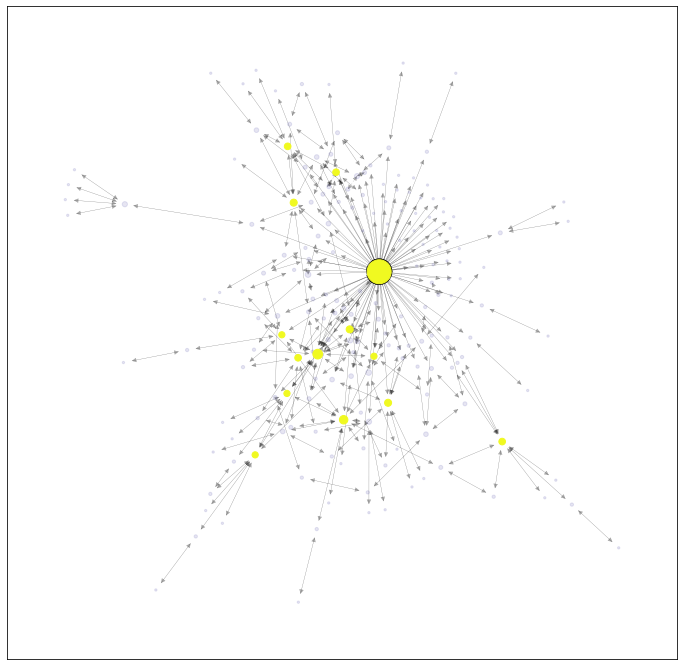

In [18]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=False)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()


In [10]:
label_dict = {
    0: "student",
    1: "project",
    2: "course",
    3: "staff",
    4: "faculty"}
    
data.y[:10]

tensor([3, 0, 2, 3, 4, 3, 0, 0, 3, 0])

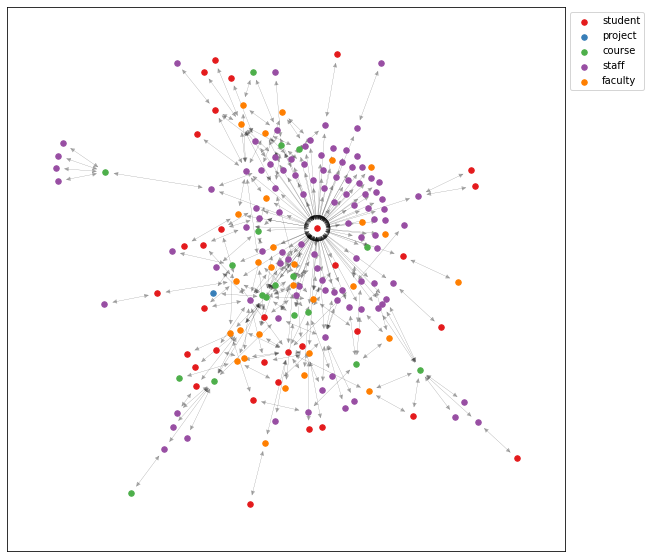

In [14]:

G = to_networkx(data, to_undirected=False)
node_color = []
nodelist = [[], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 30, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.2, alpha = 0.3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

{3: 101, 0: 33, 2: 18, 4: 30, 1: 1}


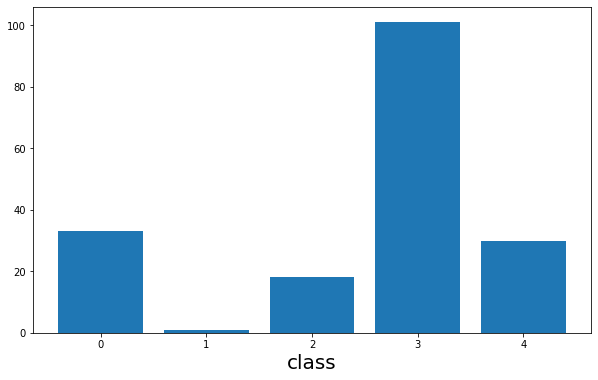

In [13]:
import collections

counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(5), count)
plt.xlabel("class", size=20)
plt.show()

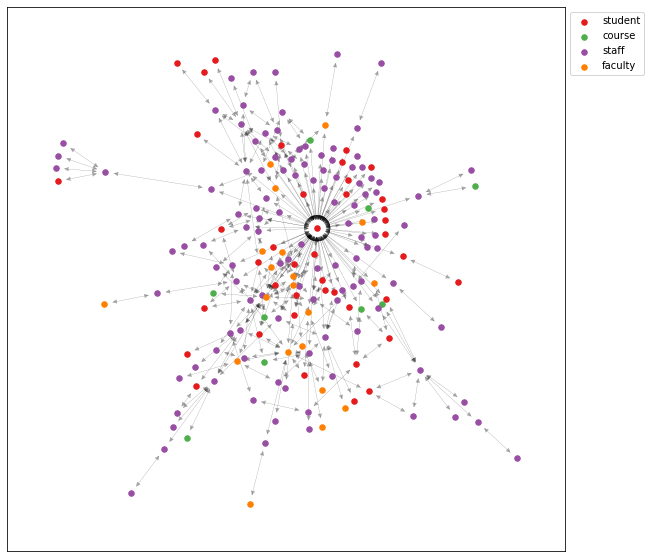

In [45]:
G = to_networkx(data, to_undirected=False)
node_color = []
nodelist = [[], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels_1 = predictions_1
for n, i in enumerate(labels_1):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 30, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.2, alpha = 0.3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()